# FNO3D Notebook

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from utilities3 import *

In [3]:
from functools import reduce
from functools import partial

In [4]:
from timeit import default_timer

In [5]:
from Adam import Adam

In [6]:
import os

device = torch.device('cuda') #test
torch.manual_seed(0)
np.random.seed(0)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

3d fourier layers

In [8]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

In [9]:
class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

Configs

In [ ]:
DATA_PATH = '/data/ns_data_V1em03_N1000_T50.mat'

modes = 8
width = 20

batch_size = 4

epochs = 500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'FNO3D/'
# path = 'ns_fourier_V100_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'models/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'models/'+path+'image/'


runtime = np.zeros(2, )
t1 = default_timer()


sub = 1
S = 64 // sub
T_in = 10
T = 40

500 0.001 100 0.5


Load data

In [13]:
reader = MatReader(DATA_PATH)
data=reader.read_field('u')[:1000] #N, 1, 64, 64, 50
# data_a=reader.read_field('a') #N, 1, 64, 64, 50

In [14]:
total_samples=data.shape[0]
ntrain_val=total_samples*.8
ntest=int(total_samples-ntrain_val)
ntrain=int(ntrain_val*.9)
nval=int(ntrain_val-ntrain)

In [15]:
ntrain,nval,ntest

(720, 80, 200)

In [17]:
train_a = data[:ntrain,::sub,::sub,:T_in]
train_u = data[:ntrain,::sub,::sub,T_in:T+T_in]

val_a = data[ntrain:ntrain+nval,::sub,::sub,:T_in]
val_u = data[ntrain:ntrain+nval,::sub,::sub,T_in:T+T_in]

test_a = data[-ntest:,::sub,::sub,:T_in]
test_u = data[-ntest:,::sub,::sub,T_in:T+T_in]

print('Train',train_a.shape, train_u.shape)
print('Val',val_a.shape, val_u.shape)
print('Test',test_a.shape, test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])


a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
val_a = a_normalizer.encode(val_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
val_a = val_a.reshape(nval,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

Train torch.Size([720, 64, 64, 10]) torch.Size([720, 64, 64, 40])
Val torch.Size([80, 64, 64, 10]) torch.Size([80, 64, 64, 40])
Test torch.Size([200, 64, 64, 10]) torch.Size([200, 64, 64, 40])
preprocessing finished, time used: 47.41335461699964


In [18]:

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_a, val_u), batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [19]:
from utilities import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
os.makedirs('models/fno3d', exist_ok=True)

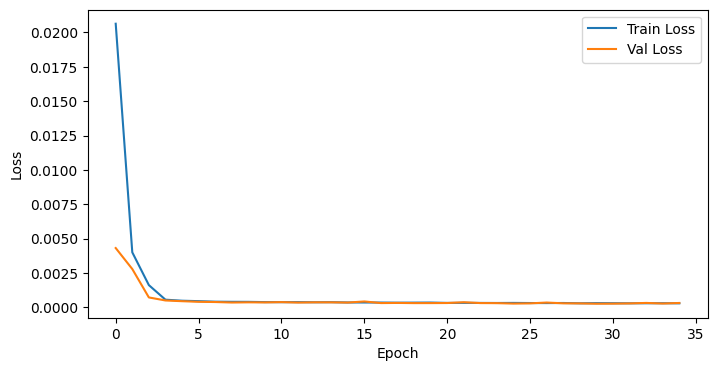

Epochs 34/500, Time: 44.56s, Train MSE: 0.000296, Val MSE: 0.000323
EarlyStopping counter: 5 out of 5
We are at epoch: 34


In [21]:
model = FNO3d(modes, modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
early_stopping = EarlyStopping(patience=5, verbose=True, path='models/fno3d/fno3d_checkpoint.pt', trace_func=print)

# myloss = LpLoss(size_average=False)
mse=nn.MSELoss()
y_normalizer.cuda()
train_losses=[]
val_losses=[]
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    val_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, S, T)

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        mse_loss = mse(out.view(batch_size, -1), y.view(batch_size, -1))
        mse_loss.backward()

        optimizer.step()
        train_mse += mse_loss.item()

    scheduler.step()

    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).view(batch_size, S, S, T)
            out = y_normalizer.decode(out)
            val_mse += mse(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= ntrain
    val_mse /= nval
    train_losses.append(train_mse)
    val_losses.append(val_mse)
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    t2 = default_timer()
    print(f'Epochs {ep}/{epochs}, Time: {t2-t1:.2f}s, Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}')
    # early stopping
    early_stopping(val_loss=val_mse,model=model)
    if early_stopping.early_stop:
        print("We are at epoch:", ep)
        break
# torch.save(model, path_model)

Evaluation & Metircs

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os


# Ensure eval mode
model.eval()
preds = []
gts = []
rel_l2_list = []
mse_list = []
mae_list = []
rmse_list = []
r2_list = []
loss_data=[]

with torch.no_grad():
    for idx, (x, y) in enumerate(zip(test_a, test_u)):
        x= x.unsqueeze(0).cuda()
        out = model(x).cpu() 
        gts.append(y.numpy())
        preds.append(out.numpy())
        mse = mean_squared_error(y.flatten(), out.flatten())
        mae = mean_absolute_error(y.flatten(), out.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(y.flatten(), out.flatten())

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        loss_data.append({'id':idx, 'mse':mse, 'mae':mae, 'rmse':rmse, 'r2':r2})

        print(f"Sample {idx:3d} | MSE: {mse:.6e} | RMSE: {rmse:.6e} | MAE: {mae:.6e} | R2: {r2:.4f}")


# summary
def summarize(metric_list, name):
    arr = np.array(metric_list)
    print(f"{name:10s} => mean: {np.mean(arr):.6e}    std: {np.std(arr):.6e}    median: {np.median(arr):.6e}")

print("\\n=== Summary over test set ===")
summarize(rel_l2_list, "rel-L2")
summarize(mse_list,   "MSE")
summarize(rmse_list,  "RMSE")
summarize(mae_list,   "MAE")
summarize(r2_list,    "R2")

Sample   0 | MSE: 8.604093e-02 | RMSE: 2.933273e-01 | MAE: 2.299070e-01 | R2: 0.8390
Sample   1 | MSE: 8.828749e-02 | RMSE: 2.971321e-01 | MAE: 2.314014e-01 | R2: 0.8459
Sample   2 | MSE: 8.818937e-02 | RMSE: 2.969670e-01 | MAE: 2.269948e-01 | R2: 0.8404
Sample   3 | MSE: 7.855751e-02 | RMSE: 2.802811e-01 | MAE: 2.166479e-01 | R2: 0.8476
Sample   4 | MSE: 8.798648e-02 | RMSE: 2.966252e-01 | MAE: 2.233582e-01 | R2: 0.8474
Sample   5 | MSE: 7.923444e-02 | RMSE: 2.814861e-01 | MAE: 2.154444e-01 | R2: 0.8456
Sample   6 | MSE: 7.951229e-02 | RMSE: 2.819792e-01 | MAE: 2.165297e-01 | R2: 0.8473
Sample   7 | MSE: 8.870870e-02 | RMSE: 2.978401e-01 | MAE: 2.250185e-01 | R2: 0.8316
Sample   8 | MSE: 7.562122e-02 | RMSE: 2.749931e-01 | MAE: 2.126401e-01 | R2: 0.8462
Sample   9 | MSE: 7.664973e-02 | RMSE: 2.768569e-01 | MAE: 2.142515e-01 | R2: 0.8506
Sample  10 | MSE: 8.372674e-02 | RMSE: 2.893557e-01 | MAE: 2.232274e-01 | R2: 0.8464
Sample  11 | MSE: 9.669924e-02 | RMSE: 3.109650e-01 | MAE: 2.3641

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [27]:
loss_df=pd.DataFrame(loss_data)
loss_df

,id,mse,mae,rmse,r2
0,0,0.086041,0.229907,0.293327,0.839025
1,1,0.088287,0.231401,0.297132,0.845885
2,2,0.088189,0.226995,0.296967,0.840358
3,3,0.078558,0.216648,0.280281,0.847634
4,4,0.087986,0.223358,0.296625,0.847384
...,...,...,...,...,...
195,195,0.082038,0.222951,0.286422,0.844636
196,196,0.076881,0.214412,0.277275,0.849186
197,197,0.083856,0.221515,0.289579,0.846398
198,198,0.075502,0.208603,0.274776,0.845616


In [28]:
max_mse_id=loss_df[loss_df['mse'] == loss_df['mse'].max()]['id'].values[0]
min_mse_id=loss_df[loss_df['mse'] == loss_df['mse'].min()]['id'].values[0]

In [59]:
results={
    'mse':np.mean(mse_list),
    'rmse':np.mean(rmse_list),
    'mae':np.mean(mae_list),
    'r2':np.mean(r2_list),
    'pred': np.array(preds).reshape(gts.shape).squeeze(),
    'gts' : np.array(gts).squeeze(),
    'rel_l2_list': np.array(rel_l2_list),
    'mse_list': np.array(mse_list),
    'mae_list': np.array(mae_list),
    'rmse_list': np.array(rmse_list),
    'r2_list': np.array(r2_list)
}
import pickle
pickle.dump(results, open('models/fno3d/ns_test_metrics.pickle', 'wb'))

In [60]:
results=pickle.load(open('models/fno3d/ns_test_metrics.pickle', 'rb'))

In [61]:
preds=results['pred']
gts=results['gts']

In [62]:
gts.shape,preds.shape

((200, 64, 64, 40), (200, 64, 64, 40))

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# assume shapes:
# target: (400, 64, 64, 40)
# pred:   (400, 64, 64, 40)
def show_time_slice_results(target_sample, pred_sample):
    # choose which time steps to visualize
    time_slices = [0, 10, 20, 30]

    fig, axs = plt.subplots(len(time_slices), 3, figsize=(12, 3*len(time_slices)))

    for i, t in enumerate(time_slices):
        err = target_sample[:,:,t] - pred_sample[:,:,t]

        # Target
        axs[i,0].imshow(target_sample[:,:,t], cmap='viridis')
        axs[i,0].set_title(f"Target (t={t})")
        axs[i,0].axis("off")

        # Prediction
        axs[i,1].imshow(pred_sample[:,:,t], cmap='viridis',
                        vmin=target_sample.min(), vmax=target_sample.max())
        axs[i,1].set_title(f"Prediction (t={t})")
        axs[i,1].axis("off")

        # Error
        axs[i,2].imshow(err, cmap='bwr')
        axs[i,2].set_title("Error")
        axs[i,2].axis("off")

    plt.tight_layout()
    plt.show()

Visualizing sample ID with max MSE: 86 MSE: 1.042820e-01


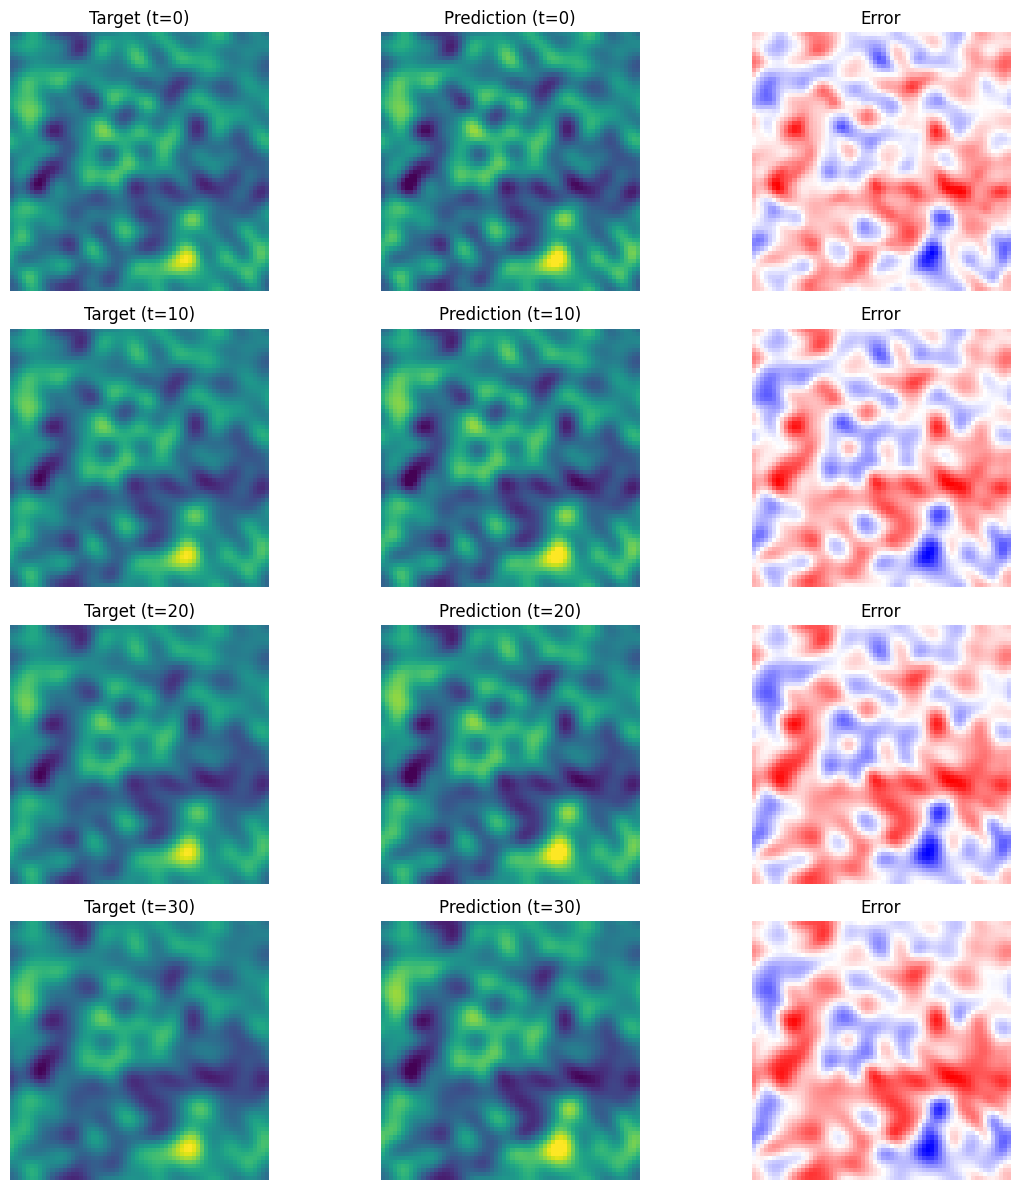

In [64]:
sample_id = max_mse_id  # change this to visualize different samples
target_sample = gts[sample_id]   # (64, 64, 40)
pred_sample   = preds[sample_id]
print(f"Visualizing sample ID with max MSE: {sample_id} MSE: {loss_df.iloc[sample_id]['mse']:.6e}")
show_time_slice_results(target_sample, pred_sample)

Visualizing sample ID with min MSE: 191 MSE: 6.909110e-02


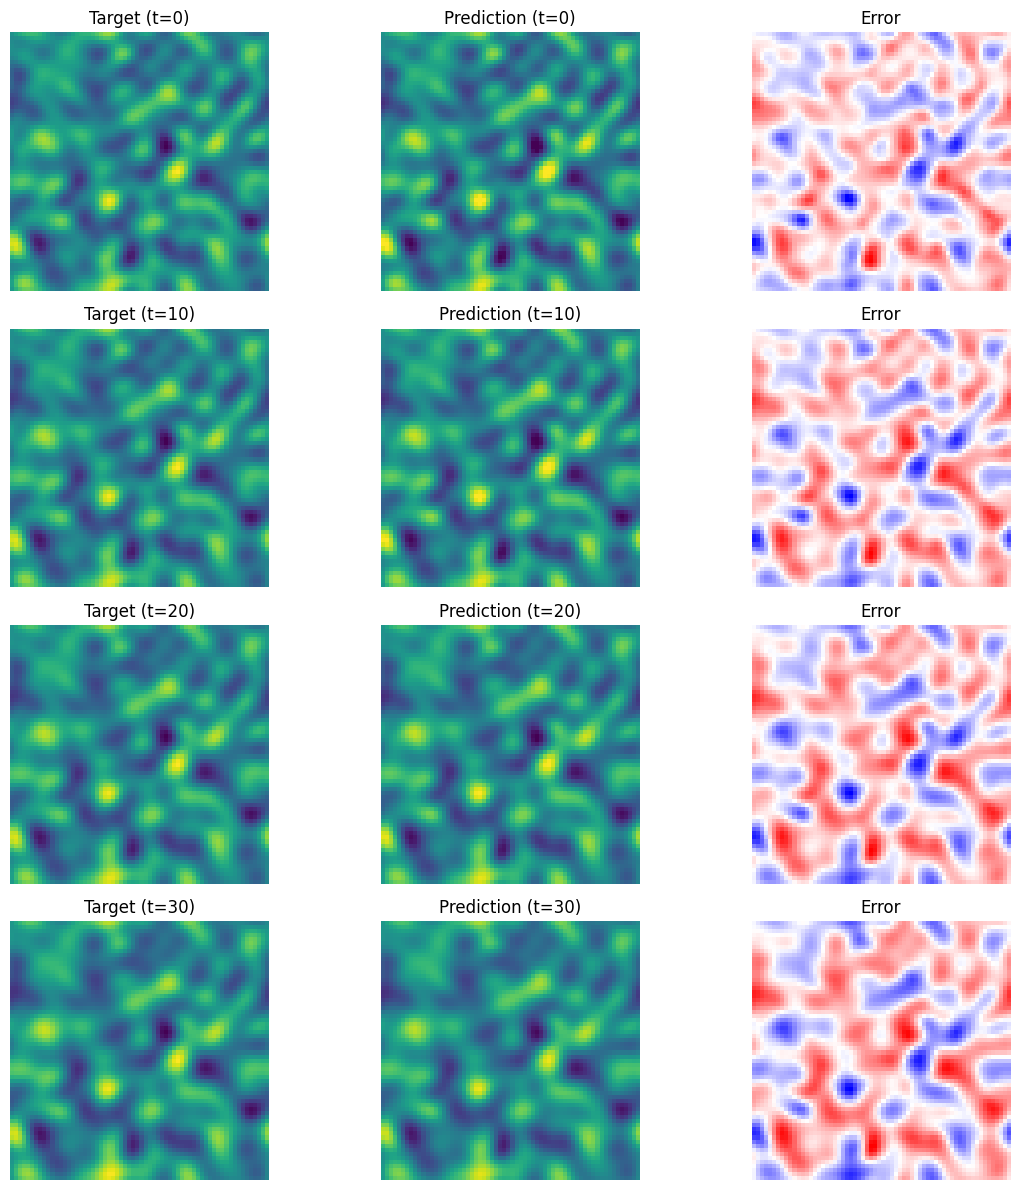

In [65]:
sample_id = min_mse_id  # change this to visualize different samples
target_sample = gts[sample_id]   # (64, 64, 40)
pred_sample   = preds[sample_id]
print(f"Visualizing sample ID with min MSE: {sample_id} MSE: {loss_df.iloc[sample_id]['mse']:.6e}")
show_time_slice_results(target_sample, pred_sample)

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def plot_l2_error_over_time(target_sample, pred_sample):
    # L2 error for each time step
    l2_error = np.linalg.norm(target_sample - pred_sample, axis=(0,1))

    plt.figure(figsize=(6,4))
    plt.plot(l2_error, linewidth=2)
    plt.xlabel("Time step")
    plt.ylabel("L2 Error")
    plt.title("Prediction Error Over Time")
    plt.grid(True)
    plt.show()

Plotting L2 error over time for sample ID: 86 MSE: 1.042820e-01 


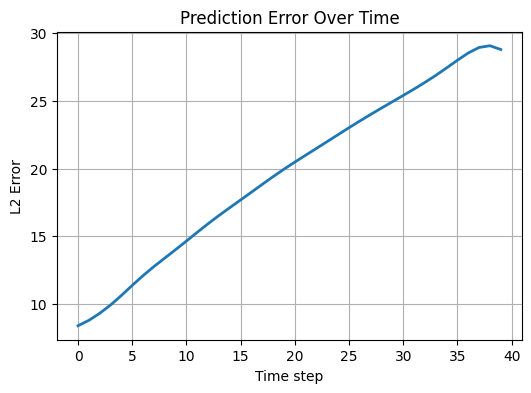

In [67]:
sample_id = max_mse_id
target_sample = gts[sample_id]
pred_sample   = preds[sample_id]
print(f"Plotting L2 error over time for sample ID: {sample_id} MSE: {loss_df.iloc[sample_id]['mse']:.6e} ")
plot_l2_error_over_time(target_sample, pred_sample)


Plotting L2 error over time for sample ID: 191 MSE: 6.909110e-02 


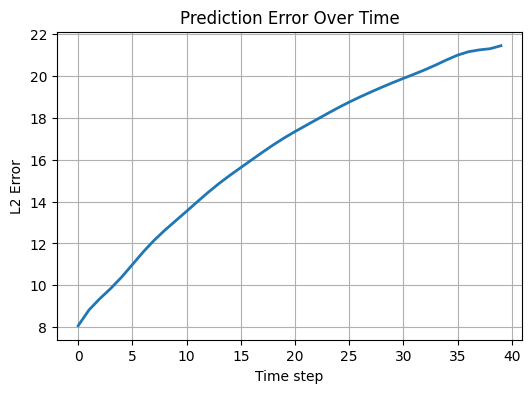

In [68]:
sample_id = min_mse_id
target_sample = gts[sample_id]
pred_sample   = preds[sample_id]
print(f"Plotting L2 error over time for sample ID: {sample_id} MSE: {loss_df.iloc[sample_id]['mse']:.6e} ")
plot_l2_error_over_time(target_sample, pred_sample)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Example shapes:
# target: (400, 64, 64, 40)
# pred:   (400, 64, 64, 40)
def animate_time_evolution(target_sample, pred_sample, filepath="models/fno3d/pde_comparison.mp4"):
    # Error
    error_sample = target_sample - pred_sample

    # Global limits for consistent color
    vmin = min(target_sample.min(), pred_sample.min())
    vmax = max(target_sample.max(), pred_sample.max())

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Initial images
    im_target = axs[0].imshow(target_sample[:, :, 0], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0].set_title("Target")
    axs[0].axis("off")

    im_pred = axs[1].imshow(pred_sample[:, :, 0], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    im_err = axs[2].imshow(error_sample[:, :, 0], cmap='bwr')
    axs[2].set_title("Error (Target - Pred)")
    axs[2].axis("off")

    plt.tight_layout()

    # Animation update function
    def update(t):
        im_target.set_data(target_sample[:, :, t])
        im_pred.set_data(pred_sample[:, :, t])
        im_err.set_data(target_sample[:, :, t] - pred_sample[:, :, t])

        axs[0].set_title(f"Target (t={t})")
        axs[1].set_title(f"Prediction (t={t})")
        axs[2].set_title(f"Error (t={t})")

        return [im_target, im_pred, im_err]

    # Create animation (40 time steps)
    anim = FuncAnimation(fig, update, frames=40, interval=150)
    # To save:
    anim.save(filename=filepath, fps=10, dpi=200)
    video=HTML(f"""
<video width="1080" controls autoplay loop muted playsinline>
  <source src="{filepath}" type="video/mp4">
</video>
""")
    return video


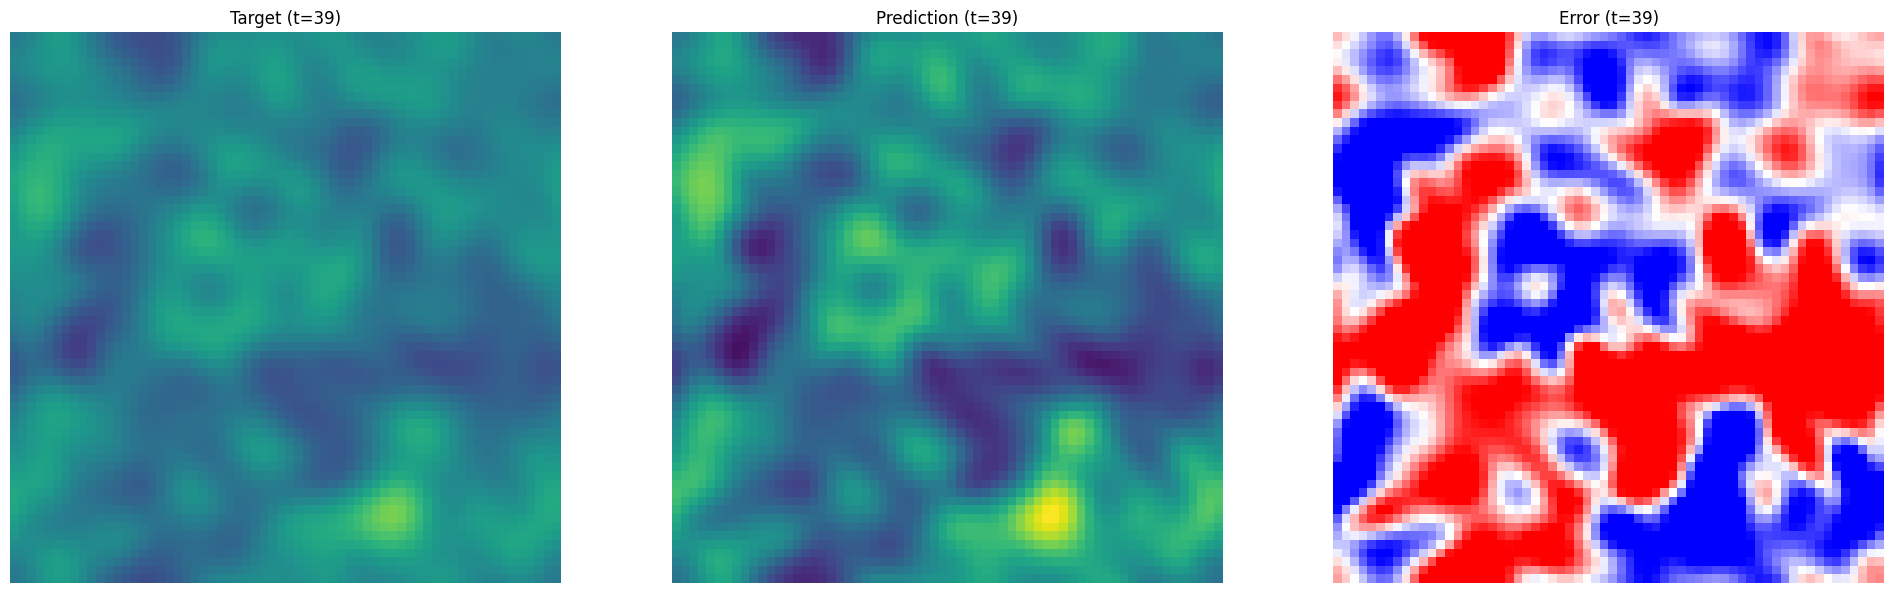

In [70]:
sample_id = max_mse_id
target_sample = gts[sample_id]     # (64, 64, 40)
pred_sample   = preds[sample_id]
max_mse_video=animate_time_evolution(target_sample, pred_sample, filepath="models/fno3d/pde_comparison_max_mse.mp4")
clear_output(wait=True)

In [71]:
print("Max MSE Sample Animation: MSE =", loss_df.iloc[sample_id]['mse'])
max_mse_video

Max MSE Sample Animation: MSE = 0.10428202152252197


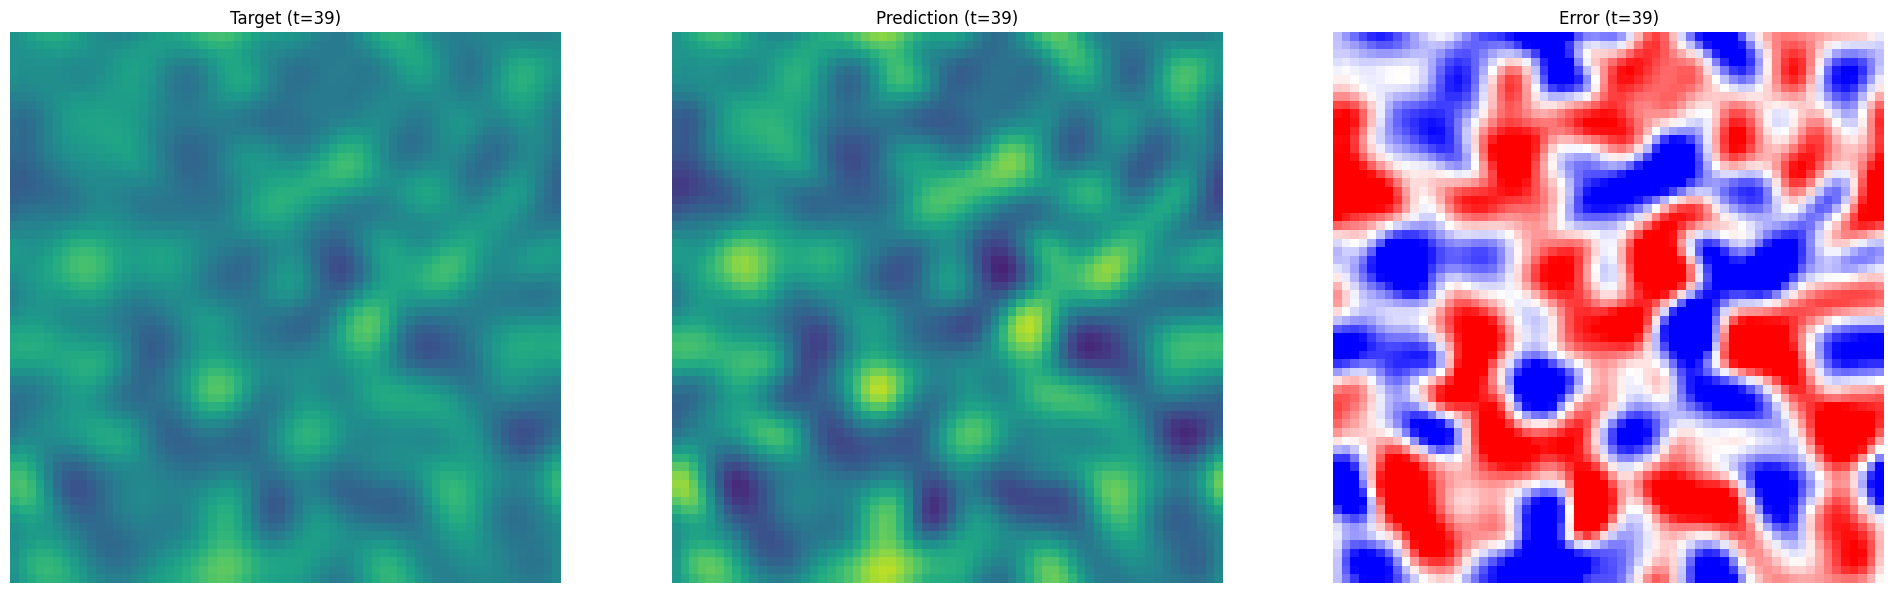

In [72]:
sample_id = min_mse_id
target_sample = gts[sample_id]     # (64, 64, 40)
pred_sample   = preds[sample_id]
min_mse_video=animate_time_evolution(target_sample, pred_sample, filepath="models/fno3d/pde_comparison_min_mse.mp4")
clear_output()

In [73]:
print("Min MSE Sample Animation: MSE =", loss_df.iloc[sample_id]['mse'])
min_mse_video

Min MSE Sample Animation: MSE = 0.06909109652042389
